In [17]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
import yaml
from datasets.adni_3d import ADNI_3D
from models.build_model import build_model

In [18]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load configuration
config_name = 'config.yaml'
with open(os.path.join('./'+config_name), 'r') as f:
    cfg = yaml.safe_load(f)

# Load dataset and data loader
dir_to_scans = '/home/atirmalle/Schreibtisch/New Folder/ADNI_processed/subjects'
dir_to_tsv = '/home/atirmalle/Schreibtisch/CNN_design_for_AD/datasets/files'
Test_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode='Test', n_label=cfg['model']['n_label'])
Test_loader = torch.utils.data.DataLoader(
    Test_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
    num_workers=cfg['data']['workers'], pin_memory=True
)

In [19]:
# Function to compute AUC
def compute_roc(targets, logits, n_classes):
    y = label_binarize(targets, classes=list(range(n_classes)))
    fpr, tpr, roc_auc = {}, {}, {}

    for k in range(n_classes):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logits[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logits.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for k in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

In [20]:
# Function to plot ROC curves
def plot_roc_curves(fpr, tpr, roc_auc, class_labels):
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    
    # Assign labels
    labels = [f"{label} ROC (area = {roc_auc[i]:.2f})" for i, label in enumerate(class_labels)]
    labels += [f"Micro ROC (area = {roc_auc['micro']:.2f})", f"Macro ROC (area = {roc_auc['macro']:.2f})"]

    # Plot each ROC curve
    for i, color in zip(list(range(len(class_labels))) + ["micro", "macro"], colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=labels.pop(0))
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

/tmp/ipykernel_2164477/1700483933.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[k], tpr[k])


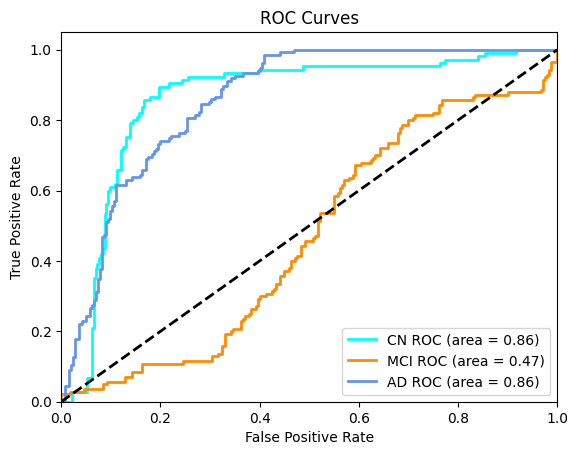

In [21]:
# Load and evaluate model
def evaluate_and_plot(model_file_name, loader):
    model = build_model(cfg)
    model_path = f'./saved_model/{model_file_name}_model_low_loss.pth.tar'
    pretrained_dict = torch.load(model_path, map_location='cpu')['state_dict']
    model_dict = model.state_dict()
    pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    model = model.to(device).eval()

    logits, targets = [], []
    with torch.no_grad():
        for inputs, target, *_ in loader:
            inputs = inputs.to(device)
            target = target.to(device)
            logit = model(inputs)
            logits.append(logit.cpu().numpy())
            targets.append(target.cpu().numpy())

    logits = np.concatenate(logits)
    targets = np.concatenate(targets)

    fpr, tpr, roc_auc = compute_roc(targets, logits, cfg['model']['n_label'])
    plot_roc_curves(fpr, tpr, roc_auc, ['CN', 'MCI', 'AD'])

# Run evaluation and plot
model_file_name = '1007_pooling_age_train_perc_100.0_expansion_0'
evaluate_and_plot(model_file_name, Test_loader)
